In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import os
import glob

from datetime import date, datetime, timedelta



TO DO
- Align these sensors with solar wind and geomagnetic activity index data
    - We have done this for Kp, Ap, and F107, but now need to do it for five-minute resolution IMF, solar wind parameters, and AE index
- Associate the latitudes with the GIC monitors and visualize
- Calculate and attach magnetic coordinates to the GIC sensor measurements
- Include the magnetometers from NERC in addition to GIC sensors
- ...


Open Questions
- What would it mean for GIC to be a self-organized system?
- What other variables do I have to account for to know whether a power law distribution in GIC is due to its intrinsic behavior vs. an artifact of a driver being SOC? (solar wind? magnetosphere? ionospheric currents? ground conductivity?)
- ...

In [2]:
# Utility Functions

def nerc_string_time_reader(df,columnLabel):
    '''
        df = dataframe with NERC data readings
        columnLabel = column label for the time strings  
    '''
    
    dt_list = [datetime.strptime(val, '%m/%d/%Y %I:%M:%S %p') for val in df[columnLabel].values]
    
    return dt_list


def nerc_gic_data_reshaping(df):
    '''
        df must have the following columns:
            GICDeviceID
            SampleDateTime
            GICMeasured
    '''
    list_times = nerc_string_time_reader(df,'SampleDateTime')
#     list_times
    
    df_times = pd.Series(list_times,name='datetimes')
    df_new = pd.concat([df,df_times],axis=1)
    df_new = df_new.set_index('datetimes')
    colName = str(df_new['GICDeviceID'].values[0])
    df_new = df_new.rename(columns={"GICMeasured": colName})
    df_new = df_new.drop(columns=['GICDeviceID','SampleDateTime'])

    
    return df_new

In [3]:
!pwd

/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx


In [4]:
# files_dir_gic = '/home/jovyan/shared/risk_resiliency_spwx/NERC_Data/event_20151220/GIC/'
files_dir_gic = '/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/'
 

In [5]:
# Read in the GIC location files

# GICs
pd_gic_locations = pd.read_csv(os.path.join(files_dir_gic,'gic_monitors.csv'))
print('number of GIC monitors = {}'.format(len(pd_gic_locations)))



number of GIC monitors = 128


In [6]:
pd_gic_locations.columns.to_list()#['Latitude']

['Device ID',
 ' Latitude',
 ' Longitude',
 ' Installation Type',
 ' Connection',
 ' Minimum Value in Measurement Range']

In [12]:
# Plot GIC locations

import plotly.express as px


fig = px.scatter_geo(pd_gic_locations,lat=' Latitude',lon=360.-pd_gic_locations[' Longitude'], hover_name="Device ID")
fig.update_layout(title = 'World map', title_x=0.5)
fig.show()

#### Create a dataframe of datetimes spanning the event and that will be used as the common index for all time series


In [7]:
event_start = datetime(2015,12,20)
event_end = datetime(2015,12,22)
df_event_dates = pd.date_range(event_start,event_end,freq='10s')

df_event_dates = df_event_dates.to_pydatetime()
df_event_dates = pd.DataFrame(df_event_dates,columns=['datetimes'])
# df_event_dates = df_event_dates.index.rename('Datetimes', inplace=True)
df_event_dates


,datetimes
0,2015-12-20 00:00:00
1,2015-12-20 00:00:10
2,2015-12-20 00:00:20
3,2015-12-20 00:00:30
4,2015-12-20 00:00:40
...,...
17276,2015-12-21 23:59:20
17277,2015-12-21 23:59:30
17278,2015-12-21 23:59:40
17279,2015-12-21 23:59:50


#### loop over files in the directory for a given event and create merged DFs for GICs

In [8]:


df_total = df_event_dates

for f in glob.glob(os.path.join(files_dir_gic,'*csv')):#[0:10]:
    
    # Skip missing data files
    if ('missing' in f) | ('monitor' in f) | ('magnetometers' in f):
        print('-------> skipping file = {}'.format(f))
        continue
    print(f)
    
    # Read and reshape the data
    df_loop = pd.read_csv(f)
    
    df_loop = nerc_gic_data_reshaping(df_loop)
            
    # Merge into full dataframe
    df_total = pd.merge(df_total, df_loop, on='datetimes',how='left')

/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10121.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10257.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10294.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10083.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10295.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10322.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10120.csv
/Users/ryanmcgranaghan/Documents/Conferen

/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10379.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10437.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10219.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10224.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10218.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10387.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10436.csv
/Users/ryanmcgranaghan/Documents/Conferen

/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10264.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10259.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10305.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10107.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10273.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10071.csv
/Users/ryanmcgranaghan/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20151220/GIC/2015E06_10065.csv
/Users/ryanmcgranaghan/Documents/Conferen

In [16]:
df_total.shape

(42787, 129)

In [18]:
df_total.iloc[1090]

datetimes    2015-12-20 03:00:00
10121                        1.6
10257                      -0.71
10294                        0.9
10083                      -0.89
                    ...         
10273                       -0.5
10071                       0.44
10065                       -0.5
10299                        0.8
10306                        5.5
Name: 1090, Length: 129, dtype: object

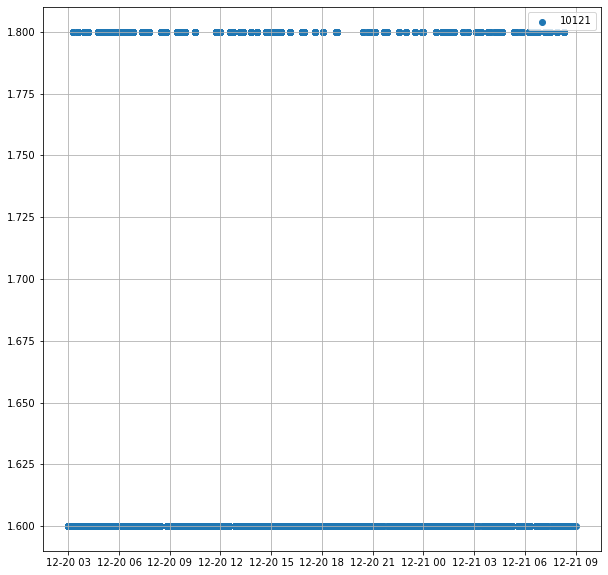

In [24]:
plot_ID = '10257'#'10121'#'10273'

fig = plt.figure(figsize=(10,10))
plt.scatter(df_total.index,
            df_total[plot_ID],
            alpha=1,
            label=plot_ID)
plt.legend()
plt.grid(True)

working on station ID = 10121
working on station ID = 10257
working on station ID = 10294
working on station ID = 10083
working on station ID = 10295
working on station ID = 10322
working on station ID = 10120
working on station ID = 10320
working on station ID = 10254


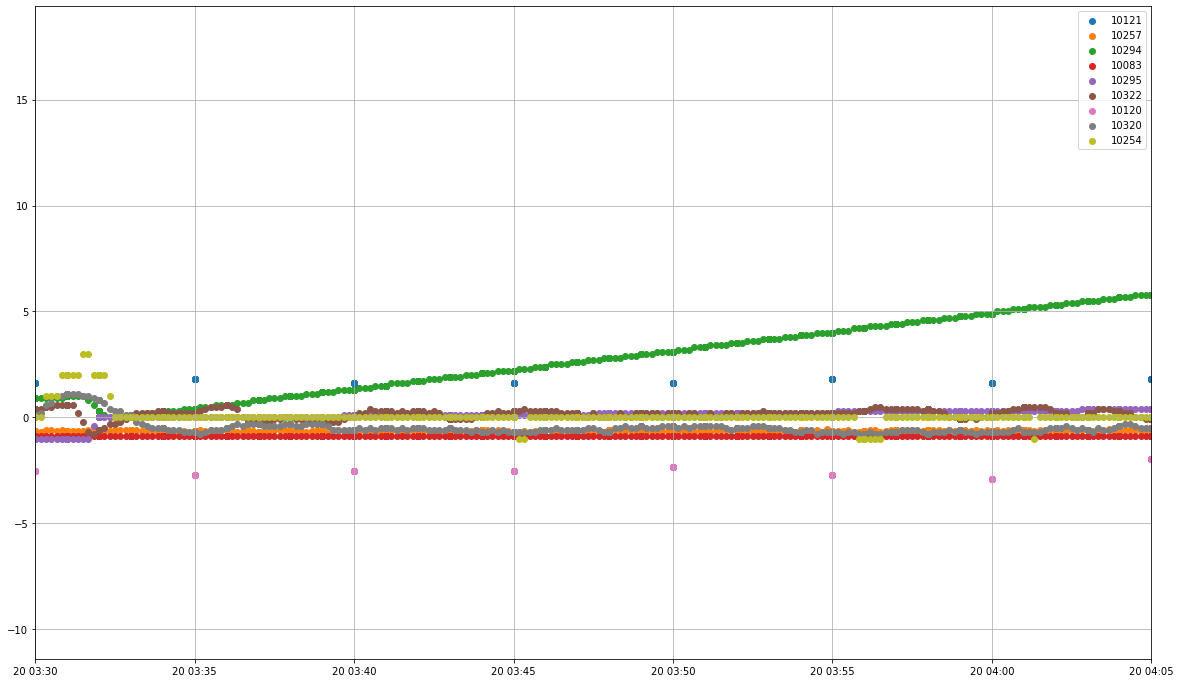

In [91]:

fig = plt.figure(figsize=(20,12))

for st in range(len(df_total.columns.to_list()))[1:10]:
    plot_ID_loop = df_total.columns.to_list()[st]
    print('working on station ID = {}'.format(plot_ID_loop))

    plt.scatter(df_total['datetimes'],
                df_total[plot_ID_loop],
                alpha=1,
                label=plot_ID_loop)
    
plt.legend()
plt.xlim([df_total['datetimes'][2000],df_total['datetimes'][3000]])

plt.grid(True)



#### Exploring the characteristics of bad station data

In [10]:
file_errors = 'gic_monitor_missing_data_data_quality_reports_2015E06.csv'
bad_gic_data = pd.read_csv(os.path.join(files_dir_gic,file_errors))
print('bad gic stations for this event = \n{}'.format(bad_gic_data['Device ID'].values))

bad gic stations for this event = 
[10291 10292 10293 10294 10295 10296]


working on station ID = 10291
working on station ID = 10292
working on station ID = 10293
working on station ID = 10294
working on station ID = 10295
working on station ID = 10296


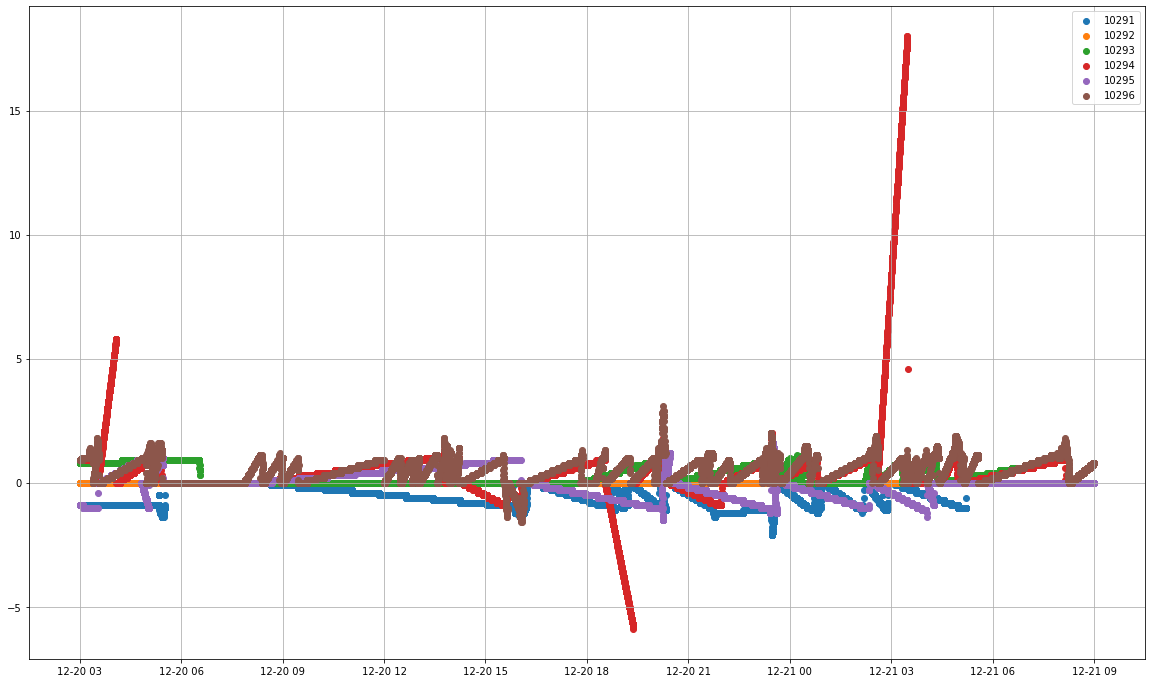

In [11]:

fig = plt.figure(figsize=(20,12))

for st in bad_gic_data['Device ID'].values:
    plot_ID_loop = str(st)
    print('working on station ID = {}'.format(plot_ID_loop))

    plt.scatter(df_total['datetimes'],
                df_total.filter(regex=plot_ID_loop),
                alpha=1,
                label=st)
    
plt.legend()

plt.grid(True)



#### Remove bad station data

In [12]:
bad_stations_string = [str(x) for x in bad_gic_data['Device ID'].values]
# bad_stations_string
df_total_dropped_bad_data = df_total.copy(True).drop(columns=bad_stations_string)


In [13]:
df_total_dropped_bad_data.shape

(42787, 123)

#### Add geomagnetic indices

In [14]:
try:
    import geomagindices as gi
except ImportError:
    !pip install geomagindices
    pass


In [15]:
# Create a dataframe of datetimes spanning the event and that will be used as the common index for all time series
event_start_geo = datetime(2015,12,20,1,30)
event_end_geo = datetime(2015,12,22,22,30)
df_event_dates_geo = pd.date_range(event_start_geo,event_end_geo,freq='10800s')

df_event_dates_geo = df_event_dates_geo.to_pydatetime()
df_event_dates_geo = pd.DataFrame(df_event_dates_geo,columns=['datetimes'])
df_event_dates_geo

,datetimes
0,2015-12-20 01:30:00
1,2015-12-20 04:30:00
2,2015-12-20 07:30:00
3,2015-12-20 10:30:00
4,2015-12-20 13:30:00
5,2015-12-20 16:30:00
6,2015-12-20 19:30:00
7,2015-12-20 22:30:00
8,2015-12-21 01:30:00
9,2015-12-21 04:30:00


In [16]:
inds = gi.get_indices(list(df_event_dates_geo['datetimes']))
print(inds)

                      Ap   Kp   f107 resolution
2015-12-20 01:30:00   27  4.0  112.8          d
2015-12-20 04:30:00   80  6.0  112.8          d
2015-12-20 07:30:00   67  5.7  112.8          d
2015-12-20 10:30:00   32  4.3  112.8          d
2015-12-20 13:30:00   56  5.3  112.8          d
2015-12-20 16:30:00   94  6.3  112.8          d
2015-12-20 19:30:00  111  6.7  112.8          d
2015-12-20 22:30:00   94  6.3  112.8          d
2015-12-21 01:30:00  111  6.7  117.8          d
2015-12-21 04:30:00   80  6.0  117.8          d
2015-12-21 07:30:00   48  5.0  117.8          d
2015-12-21 10:30:00   22  3.7  117.8          d
2015-12-21 13:30:00   15  3.0  117.8          d
2015-12-21 16:30:00    9  2.3  117.8          d
2015-12-21 19:30:00    5  1.3  117.8          d
2015-12-21 22:30:00   15  3.0  117.8          d
2015-12-22 01:30:00   12  2.7  125.8          d
2015-12-22 04:30:00    7  2.0  125.8          d
2015-12-22 07:30:00   18  3.3  125.8          d
2015-12-22 10:30:00   32  4.3  125.8    

In [17]:
inds['datetimes'] = inds.index

In [18]:
df_final = pd.merge(df_total,inds,on='datetimes',how='left')

In [19]:
df_final

,datetimes,10121,10257,10294,10083,10295,10322,10120,10320,10254,...,10107,10273,10071,10065,10299,10306,Ap,Kp,f107,resolution
0,2015-12-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-20 00:00:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-20 00:00:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-20 00:00:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-20 00:00:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42782,2015-12-21 23:59:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42783,2015-12-21 23:59:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42784,2015-12-21 23:59:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42785,2015-12-21 23:59:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_total = df_total.set_index('datetimes')
df_total

df_final = df_final.set_index('datetimes')
df_final

,10121,10257,10294,10083,10295,10322,10120,10320,10254,10297,...,10107,10273,10071,10065,10299,10306,Ap,Kp,f107,resolution
datetimes,,,,,,,,,,,,,,,,,,,,,
2015-12-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-20 00:00:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-20 00:00:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-20 00:00:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-20 00:00:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-21 23:59:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-21 23:59:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-21 23:59:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


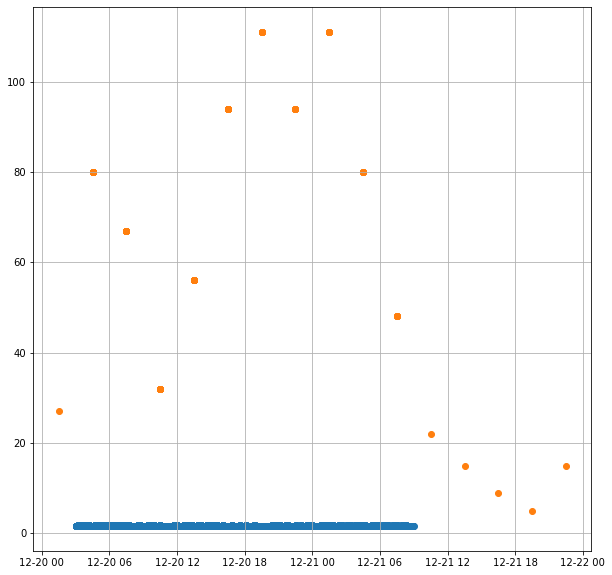

In [22]:
plot_ID = '10121'

fig = plt.figure(figsize=(10,10))
plt.scatter(df_total.index,
            df_total[plot_ID],
            alpha=1,
            label='GIC '+plot_ID)

plt.scatter(df_final.index,
            df_final['Ap'],
            alpha=1,
            label='Ap')
plt.grid(True)

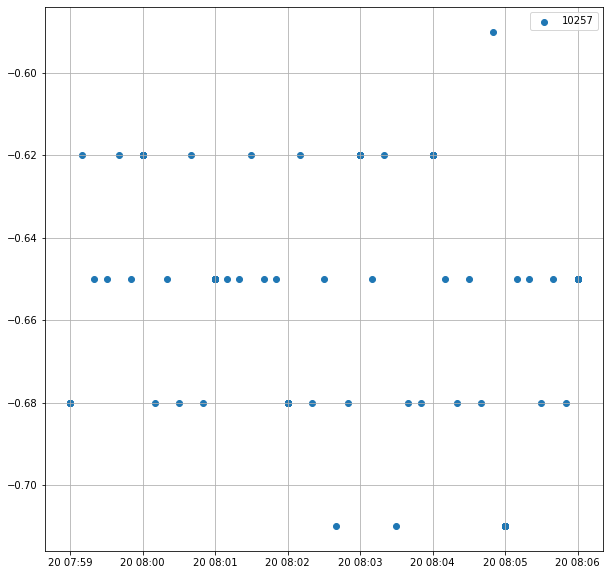

In [41]:
plot_ID = '10257'#'10121'#'10273'

fig = plt.figure(figsize=(10,10))
plt.scatter(df_total.index[9800:10000],
            df_total[plot_ID][9800:10000],
            alpha=1,
            label=plot_ID)
# plt.plot(df_total.index[0:10000],
#             df_total[plot_ID][0:10000],
#             alpha=1,
#             label=plot_ID)
plt.legend()
plt.grid(True)

#### Calculate probability density functions 
- using "Evidence for a solar wind origin of the power law burst lifetime" paper

DatetimeIndex(['2015-12-20 00:00:00', '2015-12-20 00:00:10',
               '2015-12-20 00:00:20', '2015-12-20 00:00:30',
               '2015-12-20 00:00:40', '2015-12-20 00:00:50',
               '2015-12-20 00:01:00', '2015-12-20 00:01:10',
               '2015-12-20 00:01:20', '2015-12-20 00:01:30',
               ...
               '2015-12-21 23:58:30', '2015-12-21 23:58:40',
               '2015-12-21 23:58:50', '2015-12-21 23:59:00',
               '2015-12-21 23:59:10', '2015-12-21 23:59:20',
               '2015-12-21 23:59:30', '2015-12-21 23:59:40',
               '2015-12-21 23:59:50', '2015-12-22 00:00:00'],
              dtype='datetime64[ns]', name='datetimes', length=42787, freq=None)

In [173]:
burst_durations = []
bad_columnNames = []

fig = plt.figure(figsize=(10,10))

for (columnName, columnData) in df_total.iteritems():
    plt.clf()

    print('Column Name : ', columnName)
#     print('Column Contents : ', columnData.values)
    threshold_loop = np.abs( np.nanpercentile(columnData.values,90) )
    print('  ---->  Threshold = {}'.format( threshold_loop ))

    # Begin at first non-nan point
#     idx = np.argwhere( ~np.isnan(columnData.values) )[0][0]
    # Begin at first point where threshold is exceeded
    if (np.argwhere(np.abs(columnData.values) > threshold_loop ).size == 0 ):
        print('.....no value exceeding threshold, continuing')
        # Store these time series for further examination
        bad_columnNames.append(columnName)
        continue
    idx_pointer = 0
    while idx_pointer < len(columnData.values):
        
        if all(np.abs(columnData.values[idx_pointer:]) > threshold_loop): 
            print('\t no remaining values from idx_pointer = {} and station {} fall below threshold'.format(idx_pointer, columnName))
            idx_pointer = len(columnData.values)
            continue
#         idx = np.argwhere(np.abs(columnData.values[idx_pointer:]) > threshold_loop )[0][0]
        idx = np.argwhere(np.abs(columnData.values[idx_pointer:]) > threshold_loop )
        if not(idx.size>0):
            idx_pointer = len(columnData.values)
            continue
        else:
            idx_pointer += idx[0][0]
        idx2 = np.argwhere( np.abs(columnData.values[idx_pointer:]) < threshold_loop)
        if not (idx2.size>0):
            idx_pointer = len(columnData.values)
            continue
        for i in idx2:
#             print(i)
            # Ensure the time series remains below threshold for five consecutive data points
            if ( any( np.abs(columnData.values[idx_pointer+i[0]:idx_pointer+i[0]+5]) > threshold_loop ) ):
                print('\t...the dip below threshold was not sustained')
                if i[0] == idx2[-1][0]:
                    idx_pointer += i[0]
                continue
            else:
#                 # Plot 
#                 plt_ts = plt.scatter(columnData.index,
#                                     columnData.values,
#                                     alpha=1,
#                                     label=columnName)
#                 ax = fig.gca()
# #                 plt_duration = ax.plot( [columnData.index[idx_pointer],columnData.index[idx_pointer+i[0]]], [0,0], color="red")
#                 plt.axvspan(columnData.index[idx_pointer],columnData.index[idx_pointer+i[0]], color='r', alpha=0.5, lw=0)
#                 plt.legend()
#                 plt.grid(True)
#                 plt.show()
#                 input('hit enter to continue!')
# #                 l = plt_duration.pop(0)
# #                 l.remove()

                # Calculate the duration in seconds
                difference = (columnData.index[idx_pointer+i[0]] - columnData.index[idx_pointer] ) 
                burst_durations.append(difference.total_seconds())

                # Advance idx to end of the current burst duration
                idx_pointer += i[0]
                print('...updated idx pointer = {}'.format(idx_pointer))
                
                break
        
        


Column Name :  10121
  ---->  Threshold = 1.8
.....no value exceeding threshold, continuing
Column Name :  10257
  ---->  Threshold = 0.62
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 1173
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 1632
	...the dip below threshold was not sustained
...updated idx pointer = 1682
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 1747
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 2107
	...the dip below threshold was not sustained
	...the dip below thr

...updated idx pointer = 27195
...updated idx pointer = 27265
...updated idx pointer = 27321
...updated idx pointer = 27351
...updated idx pointer = 27416
...updated idx pointer = 27482
...updated idx pointer = 27537
...updated idx pointer = 27581
...updated idx pointer = 27614
...updated idx pointer = 27684
...updated idx pointer = 27717
...updated idx pointer = 27756
...updated idx pointer = 27889
...updated idx pointer = 27966
...updated idx pointer = 28009
...updated idx pointer = 28058
...updated idx pointer = 28102
...updated idx pointer = 28132
...updated idx pointer = 28167
...updated idx pointer = 28245
...updated idx pointer = 28275
...updated idx pointer = 28318
	...the dip below threshold was not sustained
...updated idx pointer = 28454
...updated idx pointer = 28484
...updated idx pointer = 28541
...updated idx pointer = 28582
...updated idx pointer = 28729
...updated idx pointer = 28773
...updated idx pointer = 28803
...updated idx pointer = 28834
...updated idx pointer =

...updated idx pointer = 30092
...updated idx pointer = 30266
...updated idx pointer = 30397
...updated idx pointer = 30629
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 31023
...updated idx pointer = 31091
...updated idx pointer = 31210
...updated idx pointer = 31861
...updated idx pointer = 31973
	...the dip below threshold was not sustained
...updated idx pointer = 32204
...updated idx pointer = 32257
...updated idx pointer = 32841
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 33268
...updated idx pointer = 33488
...updated idx pointer = 33569
...updated idx pointer = 34798
...updated idx pointer = 34911
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 35779
	...the dip below threshold 

...updated idx pointer = 23451
...updated idx pointer = 23570
...updated idx pointer = 23984
...updated idx pointer = 24128
...updated idx pointer = 24479
...updated idx pointer = 24565
...updated idx pointer = 24648
...updated idx pointer = 24728
...updated idx pointer = 25193
...updated idx pointer = 25324
...updated idx pointer = 25438
...updated idx pointer = 25952
...updated idx pointer = 26077
...updated idx pointer = 26486
...updated idx pointer = 26700
...updated idx pointer = 26791
...updated idx pointer = 27009
...updated idx pointer = 27033
...updated idx pointer = 27077
...updated idx pointer = 27156
...updated idx pointer = 27230
...updated idx pointer = 27342
...updated idx pointer = 27460
...updated idx pointer = 27503
...updated idx pointer = 27525
...updated idx pointer = 27571
...updated idx pointer = 27613
...updated idx pointer = 27715
...updated idx pointer = 27739
...updated idx pointer = 27772
...updated idx pointer = 27890
...updated idx pointer = 27977
...updat

...updated idx pointer = 37285
...updated idx pointer = 37349
Column Name :  10252
  ---->  Threshold = 1.3
...updated idx pointer = 1803
...updated idx pointer = 2197
...updated idx pointer = 5308
...updated idx pointer = 5751
...updated idx pointer = 6458
...updated idx pointer = 7754
...updated idx pointer = 12483
...updated idx pointer = 20538
...updated idx pointer = 20650
...updated idx pointer = 21751
...updated idx pointer = 24275
...updated idx pointer = 25421
...updated idx pointer = 26154
...updated idx pointer = 26405
...updated idx pointer = 26521
...updated idx pointer = 27208
...updated idx pointer = 28374
...updated idx pointer = 29276
...updated idx pointer = 30114
...updated idx pointer = 30256
...updated idx pointer = 30979
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 31017
...updated idx pointer = 31100
.

	...the dip below threshold was not sustained
...updated idx pointer = 28222
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 28267
	...the dip below threshold was not sustained
...updated idx pointer = 28278
...updated idx pointer = 28288
	...the dip below threshold was not sustained
...updated idx pointer = 29025
...updated idx pointer = 29143
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 29180
...updated idx pointer = 29209
...updated idx pointer = 29960
...updated idx pointer = 29968
...updated idx pointer = 29981
...updated idx pointer = 30046
...updated idx pointer = 30081
...updated idx pointer = 31094
...updated idx pointer = 31138
...updated idx pointer = 31148
	...the dip below threshold was not sustained
...updated idx pointer = 31863
...updated idx pointer = 32002
...updated idx pointer = 32060
	...the dip below threshold was not sustain

...updated idx pointer = 5751
...updated idx pointer = 6726
...updated idx pointer = 6899
...updated idx pointer = 6931
	...the dip below threshold was not sustained
...updated idx pointer = 7543
	...the dip below threshold was not sustained
...updated idx pointer = 8202
	...the dip below threshold was not sustained
...updated idx pointer = 8835
...updated idx pointer = 10674
...updated idx pointer = 12352
...updated idx pointer = 12483
...updated idx pointer = 17132
	...the dip below threshold was not sustained
...updated idx pointer = 17558
...updated idx pointer = 17591
...updated idx pointer = 17630
...updated idx pointer = 17946
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 18151
...updated idx pointer = 20296
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 20393
...updated idx pointer = 20438
	...

	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 23871
...updated idx pointer = 23905
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 23987
...updated idx pointer = 24069
	...the dip below threshold was not sustained
...updated idx pointer = 24129
...updated idx pointer = 24310
...updated idx pointer = 24353
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 24426
...updated idx pointer = 24455
...updated idx pointer = 24510
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained


...updated idx pointer = 30191
...updated idx pointer = 30223
...updated idx pointer = 30266
...updated idx pointer = 30280
...updated idx pointer = 30287
...updated idx pointer = 30352
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 30411
...updated idx pointer = 30456
...updated idx pointer = 30500
	...the dip below threshold was not sustained
...updated idx pointer = 30539
	...the dip below threshold was not sustained
...updated idx pointer = 30610
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 30693
...updated idx pointer = 30708
...updated idx pointer = 30731
...updated idx pointer = 30773
...updated idx pointer = 30797
...updated idx pointer = 30806
	...the dip b

...updated idx pointer = 4937
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 4990
...updated idx pointer = 5019
...updated idx pointer = 5051
...updated idx pointer = 5136
...updated idx pointer = 5175
...updated idx pointer = 5276
...updated idx pointer = 5326
...updated idx pointer = 6055
...updated idx pointer = 6226
...updated idx pointer = 6802
...updated idx pointer = 7085
...updated idx pointer = 7368
...updated idx pointer = 8045
...updated idx pointer = 9279
...updated idx pointer = 9652
...updated idx pointer = 9929
...updated idx pointer = 13366
...updated idx pointer = 15100
...updated idx pointer = 17517
...updated idx pointer = 17632
...updated idx pointer = 18326
...updated idx pointer = 19463
...updated idx pointer = 19507
...updated idx pointer = 19653
...updated idx pointer = 19944
...updated idx pointer = 20511
...updated idx pointer = 20729
...updated idx pointer = 20877
...updated idx pointer = 2

...updated idx pointer = 21953
...updated idx pointer = 22248
...updated idx pointer = 23565
...updated idx pointer = 23798
...updated idx pointer = 24092
...updated idx pointer = 24306
...updated idx pointer = 24321
...updated idx pointer = 24510
...updated idx pointer = 27406
...updated idx pointer = 27651
...updated idx pointer = 28289
...updated idx pointer = 28299
...updated idx pointer = 28331
...updated idx pointer = 28396
...updated idx pointer = 28594
...updated idx pointer = 29188
	...the dip below threshold was not sustained
...updated idx pointer = 29441
	...the dip below threshold was not sustained
...updated idx pointer = 29560
...updated idx pointer = 30510
...updated idx pointer = 30577
...updated idx pointer = 30805
...updated idx pointer = 31145
...updated idx pointer = 31280
...updated idx pointer = 31486
...updated idx pointer = 32269
...updated idx pointer = 32511
...updated idx pointer = 32621
...updated idx pointer = 32733
...updated idx pointer = 33073
...update

	...the dip below threshold was not sustained
...updated idx pointer = 23798
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 24029
...updated idx pointer = 24272
...updated idx pointer = 24319
...updated idx pointer = 25251
...updated idx pointer = 27396
...updated idx pointer = 27593
	...the dip below threshold was not sustained
...updated idx pointer = 27649
...updated idx pointer = 27924
...updated idx pointer = 27935
...updated idx pointer = 28020
...updated idx pointer = 28035
...updated idx pointer = 28355
...updated idx pointer = 28388
	...the dip below threshold was not sustained
...updated idx pointer = 28593
	...the dip below threshold was not sustained
...updated idx pointer = 29044
...updated idx pointer = 29443
...updated idx pointer = 29585
...updated idx pointer = 30115
...updated idx pointer = 30158
...updated idx pointer = 30168
	...the dip below threshold

...updated idx pointer = 11113
...updated idx pointer = 15523
...updated idx pointer = 15588
...updated idx pointer = 15676
...updated idx pointer = 20364
...updated idx pointer = 20437
...updated idx pointer = 21875
...updated idx pointer = 22386
...updated idx pointer = 23490
...updated idx pointer = 23538
...updated idx pointer = 23798
	...the dip below threshold was not sustained
...updated idx pointer = 24090
...updated idx pointer = 24272
...updated idx pointer = 24354
...updated idx pointer = 24484
...updated idx pointer = 25030
...updated idx pointer = 25195
...updated idx pointer = 25252
...updated idx pointer = 27405
...updated idx pointer = 27650
...updated idx pointer = 28331
...updated idx pointer = 28396
...updated idx pointer = 28592
...updated idx pointer = 29188
...updated idx pointer = 29442
...updated idx pointer = 29541
...updated idx pointer = 30511
...updated idx pointer = 30574
...updated idx pointer = 30973
...updated idx pointer = 31137
...updated idx pointer =

...updated idx pointer = 29773
...updated idx pointer = 29791
...updated idx pointer = 29807
...updated idx pointer = 29837
...updated idx pointer = 29869
...updated idx pointer = 29926
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 30000
...updated idx pointer = 30012
...updated idx pointer = 30026
	...the dip below threshold was not sustained
...updated idx pointer = 30093
...updated idx pointer = 30213
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 30247
...updated idx pointer = 30258
...updated idx pointer = 30280
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 30334
...updated idx pointer = 30357
...updated idx pointer = 30378
	...the dip below threshold was not sustained
...updated idx pointer = 30401
...updated idx pointer = 304

...updated idx pointer = 31753
...updated idx pointer = 31772
...updated idx pointer = 31807
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 32347
	...the dip below threshold was not sustained
...updated idx pointer = 32578
...updated idx pointer = 32612
...updated idx pointer = 32623
	...the dip below threshold was not sustained
...updated idx pointer = 32689
	...the dip below threshold was not sustained
...updated idx pointer = 32709
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 32799
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 32997
...updated idx pointer = 33018
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold wa

...updated idx pointer = 22761
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 22848
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 23019
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 23107
...updated idx pointer = 23145
...updated idx pointer = 23211
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 23281
	

...updated idx pointer = 29267
...updated idx pointer = 29287
...updated idx pointer = 29395
...updated idx pointer = 29970
...updated idx pointer = 30067
...updated idx pointer = 30201
...updated idx pointer = 30311
...updated idx pointer = 30836
...updated idx pointer = 30970
...updated idx pointer = 30995
...updated idx pointer = 31013
...updated idx pointer = 31093
...updated idx pointer = 31101
...updated idx pointer = 31193
...updated idx pointer = 31278
...updated idx pointer = 31576
...updated idx pointer = 31633
...updated idx pointer = 31827
...updated idx pointer = 31951
...updated idx pointer = 32179
...updated idx pointer = 32248
...updated idx pointer = 32348
...updated idx pointer = 32806
...updated idx pointer = 32963
...updated idx pointer = 33202
...updated idx pointer = 33282
...updated idx pointer = 33756
...updated idx pointer = 33873
...updated idx pointer = 33973
...updated idx pointer = 34075
...updated idx pointer = 34213
...updated idx pointer = 34437
...updat

...updated idx pointer = 30808
...updated idx pointer = 30817
...updated idx pointer = 30851
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 30883
...updated idx pointer = 30913
	...the dip below threshold was not sustained
...updated idx pointer = 30927
...updated idx pointer = 30938
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 30968
...updated idx pointer = 30980
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 31004
...updated idx pointer = 31015
...updated idx 

...updated idx pointer = 23348
	...the dip below threshold was not sustained
...updated idx pointer = 23798
...updated idx pointer = 23819
...updated idx pointer = 24204
...updated idx pointer = 24564
...updated idx pointer = 24683
...updated idx pointer = 24727
...updated idx pointer = 24823
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 24924
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 25089
...updated idx pointer = 25524
...updated idx pointer = 28200
...updated idx pointer = 28328
...updated idx pointer = 28914
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 28968
...updated idx pointer = 29001
...updated idx pointer = 29047
...updated id

...updated idx pointer = 11638
...updated idx pointer = 11644
...updated idx pointer = 11650
...updated idx pointer = 11656
...updated idx pointer = 11662
...updated idx pointer = 12007
...updated idx pointer = 12013
...updated idx pointer = 12019
...updated idx pointer = 12025
...updated idx pointer = 12031
...updated idx pointer = 12276
...updated idx pointer = 12282
...updated idx pointer = 12377
...updated idx pointer = 12395
...updated idx pointer = 12401
...updated idx pointer = 12407
...updated idx pointer = 12413
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 12832
...updated idx pointer = 12838
	...the dip below threshold was not sustained
	...the dip below threshold was not sustain

...updated idx pointer = 9407
...updated idx pointer = 9470
...updated idx pointer = 9589
...updated idx pointer = 9632
	...the dip below threshold was not sustained
...updated idx pointer = 9687
...updated idx pointer = 9705
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 9781
...updated idx pointer = 9888
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 10035
...updated idx pointer = 10068
	...the dip below threshold was not sustained
...updated idx pointer = 10132
...updated idx pointer = 10200
...updated idx pointer = 10240
...updated idx pointer = 10264
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below thre

...updated idx pointer = 2143
...updated idx pointer = 2315
...updated idx pointer = 4269
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 4334
...updated idx pointer = 4363
	...the dip below threshold was not sustained
	...the dip below threshold was not sustained
...updated idx pointer = 4986
...updated idx pointer = 5245
...updated idx pointer = 5925
...updated idx pointer = 6507
...updated idx pointer = 6724
...updated idx pointer = 7051
...updated idx pointer = 7657
...updated idx pointer = 7755
...updated idx pointer = 7807
...updated idx pointer = 8330
...updated idx pointer = 8562
...updated idx pointer = 8695
...updated idx pointer = 10334
...updated idx pointer = 10627
...updated idx pointer = 11020
...updated idx pointer = 11734
...updated idx pointer = 12698
...updated idx pointer = 12738
...updated idx pointer = 12969
...updated idx pointer = 13288
...updated i

<Figure size 720x720 with 0 Axes>

In [174]:
len(burst_durations)

9699

In [181]:
burst_durations_df = pd.DataFrame(data=burst_durations,columns=['burst durations'])
burst_durations_df.describe()

,burst durations
count,9699.000000
mean,465.164450
std,2211.940413
min,0.000000
25%,30.000000
50%,80.000000
75%,280.000000
max,74050.000000


In [191]:
np.log10(0.0)

<ipython-input-191-c77b670d6ba4>:1: RuntimeWarning: divide by zero encountered in log10
  np.log10(0.0)


-inf

In [175]:
bad_columnNames

['10121', '10292', '10408', '10434', '10224', '10065']

#### Calculate the PDF

In [207]:
bins_duration=np.logspace(np.log10(1.0),np.log10(1000.0), 50)
bins_duration_centers = 0.5*(bins_duration[1:] + bins_duration[:-1])


In [208]:
bins_duration_centers

array([  1.0756977 ,   1.23855338,   1.42606467,   1.6419643 ,
         1.89055014,   2.17677073,   2.5063238 ,   2.8857697 ,
         3.32266195,   3.82569768,   4.40489071,   5.0717709 ,
         5.83961368,   6.72370433,   7.74164223,   8.91369125,
        10.26318309,  11.81698179,  13.60601847,  15.66590707,
        18.03765333,  20.76847106,  23.91272203,  27.53299813,
        31.70136737,  36.50080854,  42.02686303,  48.38953674,
        55.71548998,  64.15055883,  73.8626583 ,  85.04512495,
        97.92056561, 112.74528874, 129.81440675, 149.4677107 ,
       172.09643445, 198.15104286, 228.15019912, 262.69108963,
       302.46131204, 348.25256316, 400.97639902, 461.68238107,
       531.57896952, 612.05757988, 704.7202816 , 811.41169004,
       934.25568688])

list

In [238]:
counts = []
counts_norm = []
N = len(burst_durations)
burst_durations_array = np.array(burst_durations)

for b in range(len(bins_duration)-1):
    mask = ( burst_durations_array > bins_duration[b] ) & ( burst_durations_array <= bins_duration[b+1] )
    counts.append( len(burst_durations_array[mask]) )
    counts_norm.append( len(burst_durations_array[mask]) / (N*(bins_duration[b+1]-bins_duration[b])) )
    

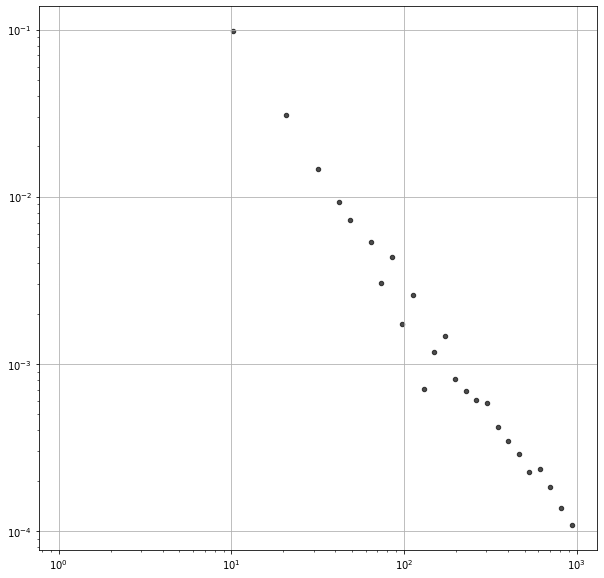

In [245]:
fig = plt.figure(figsize=(10,10))
plt.scatter(bins_duration_centers,counts_norm,20,'k',alpha=0.7)
# plt.plot(bins_duration_centers,counts_norm,'k--',alpha=0.3)
# plt.xlim()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)



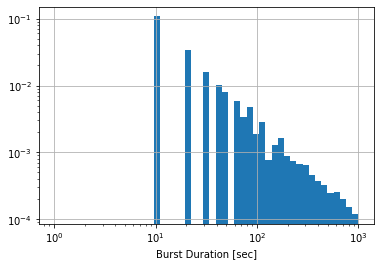

In [227]:
plt.hist(burst_durations, bins=np.logspace(np.log10(1.0),np.log10(1000), 50),density=True)
plt.gca().set_xscale("log")
plt.grid(True)
plt.xlabel('Burst Duration [sec]')
plt.yscale('log')
plt.show()


In [220]:
counts, bins = np.histogram(burst_durations, bins=np.logspace(np.log10(1.0),np.log10(1000), 50))